In [178]:
import seaborn as sns
import matplotlib.pyplot as plt

In [179]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Send an HTTP GET request to the URL
url = 'https://www.airlinequality.com/airline-reviews/british-airways/page/{}/?sortby=post_date%3ADesc&pagesize=100'


# Extract review data
reviews = []


for page_num in range(1, 37):
    print('page: '+str(page_num))
    page_url = url.format(page_num)
    response = requests.get(page_url)
    # Parse the response using BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')

# for url in range(1,11):

    for review in soup.find_all('div', {'class': 'body'}):
        try:
            subject = review.find('h2', {'class': 'text_header'}).text.strip()
        except AttributeError:
            subject = None
        try:
            author = review.find('span', {'itemprop': 'name'}).text.strip()
        except AttributeError:
            author = None
        try:
            date = review.find('time', {'itemprop': 'datePublished'}).text.strip()
        except AttributeError:
            date = None
        try:
            body = review.find('div', {'class': 'text_content', 'itemprop': 'reviewBody'}).text.strip()
        except AttributeError:
            body = None
        try:
            type_of_traveler = review.find('td', {'class': 'review-rating-header type_of_traveller'}).find_next_sibling('td').text.strip()
        except AttributeError:
            type_of_traveler = None
        try:
            seat_type = review.find('td', {'class': 'review-rating-header cabin_flown'}).find_next_sibling('td').text.strip()
        except AttributeError:
            seat_type = None
        try:
            route = review.find('td', {'class': 'review-rating-header route'}).find_next_sibling('td').text.strip()
        except AttributeError:
            route = None
        try:
            date_flown = review.find('td', {'class': 'review-rating-header date_flown'}).find_next_sibling('td').text.strip()
        except AttributeError:
            date_flown = None
        try:
            recommended = review.find('td', {'class':"review-rating-header recommended"}).find_next_sibling('td').text.strip()
        except AttributeError:
            recommended = None

        review_data = {
            'subject': subject,
            'author': author,
            'date': date,
            'body': body,
            'type_of_traveler': type_of_traveler,
            'seat_type': seat_type,
            'route': route,
            'date_flown': date_flown,
            'recommended': recommended
        }
        reviews.append(review_data)

# Convert the reviews list to a pandas dataframe
df = pd.DataFrame(reviews)

# Print the dataframe
df

In [180]:
# df.to_csv('/content/reviews.csv')
df = pd.read_csv('/content/reviews.csv')

In [181]:
# nltk.download('stopwords')
# pip install pyLDAvis

In [182]:
import nltk
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [183]:
stop_words = stopwords.words('english')
stop_words.extend(['flight', 'frontier', 'airline', 'airlines', 'plane', 'flight', 'flights', 'fly', 'flying','london','heathrow', 'ba','airways','british','verified','lhr'])

# Define a tokenizer to tokenize the reviews
tokenizer = RegexpTokenizer(r'\w+')

# Tokenize the reviews and remove stop words
tokenized_reviews = []
for review in df['body']:
    tokens = tokenizer.tokenize(review.lower())
    tokens = [token for token in tokens if token not in stop_words]
    tokenized_reviews.append(tokens)

# Create a dictionary from the tokenized reviews
dictionary = corpora.Dictionary(tokenized_reviews)

# Convert the tokenized reviews into a document-term matrix
doc_term_matrix = [dictionary.doc2bow(tokens) for tokens in tokenized_reviews]

# Train the LDA model
lda_model = LdaModel(doc_term_matrix, num_topics=5, id2word=dictionary, passes=10)

# Compute the coherence score to evaluate the model
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_reviews, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score:', coherence_lda)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, doc_term_matrix, dictionary)
vis

Coherence Score: 0.4132481380665922


/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.063145  0.052440       1        1  23.874660
3      0.120910  0.028655       2        1  20.800806
0      0.066083 -0.113088       3        1  18.624314
1     -0.176183 -0.029964       4        1  18.492850
4     -0.073954  0.061957       5        1  18.207371, topic_info=         Term         Freq        Total Category  logprob  loglift
216      seat  2207.000000  2207.000000  Default  30.0000  30.0000
217     seats  1999.000000  1999.000000  Default  29.0000  29.0000
320     class  1701.000000  1701.000000  Default  28.0000  28.0000
491      good  1973.000000  1973.000000  Default  27.0000  27.0000
835  business  1413.000000  1413.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
23        get   190.019175  1191.939899   Topic5  -5.5805  -0.1329
181      food   205.623031  2186.154323   Topic5  -5.5016  -0.6605
73       crew   200.455430  1961.993208   Topic5  -5.5271  -0.5778
491      good   192.083698  1973.292694   Topic5  -5.5697  -0.6262
596     would   184.651724  1389.064382   Topic5  -5.6092  -0.3146

[459 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
599       5  0.926852       05
428       1  0.147686        1
428       2  0.096667        1
428       3  0.147686        1
428       4  0.187964        1
...     ...       ...      ...
596       5  0.133183    would
2447      3  0.936038      yin
3602      1  0.966694  yoghurt
5854      5  0.867588       yr
3537      2  0.961197      zrh

[1124 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 2, 5])

In [184]:
# Get the top N frequent words in each topic
N = 15
topics = lda_model.show_topics(num_topics=-1, num_words=N, formatted=False)
topic_words = [(i, [w[0] for w in topic]) for i, topic in topics]

# Assign a topic to each review
reviews_topics = []
for i in range(len(doc_term_matrix)):
    topic_dist = lda_model.get_document_topics(doc_term_matrix[i])
    topic_id = max(topic_dist, key=lambda x: x[1])[0]
    reviews_topics.append(topic_id)

# Create a new table with columns for topic, frequent words, and reviews
topics_df = pd.DataFrame(columns=['topic', 'frequent_words', 'reviews'])
for topic_id, words in topic_words:
    topic_reviews = [df['body'][i] for i, t in enumerate(reviews_topics) if t == topic_id]
    topic_df = pd.DataFrame({'topic': [f'Topic {topic_id}'], 'frequent_words': [', '.join(words)], 'reviews': [topic_reviews]})
    topics_df = topics_df.append(topic_df)

# Print the table
topics_df

<ipython-input-184-b9c674d4d450>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topics_df = topics_df.append(topic_df)
<ipython-input-184-b9c674d4d450>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topics_df = topics_df.append(topic_df)
<ipython-input-184-b9c674d4d450>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topics_df = topics_df.append(topic_df)
<ipython-input-184-b9c674d4d450>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topics_df = topics_df.append(topic_df)
<ipython-input-184-b9c674d4d450>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

,topic,frequent_words,reviews
0,Topic 0,"seat, seats, class, business, economy, food, g...",[✅ Trip Verified | I was horrified by the ext...
0,Topic 1,"told, us, would, customer, get, hours, trip, s...",[Not Verified | I was meant to fly in January ...
0,Topic 2,"crew, food, service, cabin, time, first, loung...","[Not Verified | Flew premium, only worth the ..."
0,Topic 3,"good, food, crew, seat, cabin, service, time, ...",[✅ Trip Verified | First time flying with Brit...
0,Topic 4,"check, time, service, boarding, staff, passeng...",[✅ Trip Verified | The latest affront. Stood ...


In [185]:
# Create a new DataFrame to store the topic information for each review
topic_df = pd.DataFrame(columns=['Review', 'Topic', 'Top Words', 'Topic Probability'])

# Get the topic distribution for each review and the top words for each topic
for i, review in enumerate(tokenized_reviews):
    topic_dist = lda_model.get_document_topics(doc_term_matrix[i], minimum_probability=0.0)
    topic_dist = sorted(topic_dist, key=lambda x: x[1], reverse=True)
    top_topic = topic_dist[0][0]
    top_words = lda_model.show_topic(top_topic, topn=15)
    topic_words = [word[0] for word in top_words]
    topic_prob = topic_dist[0][1]
    topic_df.loc[i] = [df['body'][i], top_topic, topic_words, topic_prob]



In [201]:
topic_df[topic_df['Topic']==1]

,Review,Topic,Top Words,Topic Probability
0,Not Verified | I was meant to fly in January t...,1,"[told, us, would, customer, get, hours, trip, ...",0.910605
1,✅ Trip Verified | We have flown repeatedly wi...,1,"[told, us, would, customer, get, hours, trip, ...",0.994467
6,Not Verified | Booked a flight return flight ...,1,"[told, us, would, customer, get, hours, trip, ...",0.991176
7,✅ Trip Verified | I tried to check in on line...,1,"[told, us, would, customer, get, hours, trip, ...",0.591727
10,Not Verified | If I could give a minus rating...,1,"[told, us, would, customer, get, hours, trip, ...",0.601094
...,...,...,...,...
3458,When we booked our holiday to Barbados I was r...,1,"[told, us, would, customer, get, hours, trip, ...",0.439336
3459,LGW-Antigua on 29 April and Antigua-LGW on 13 ...,1,"[told, us, would, customer, get, hours, trip, ...",0.693912
3467,On a recent vacation from Sacramento to Paris ...,1,"[told, us, would, customer, get, hours, trip, ...",0.443977
3468,I should be in a nice hotel in Romania instead...,1,"[told, us, would, customer, get, hours, trip, ...",0.993163


In [187]:
topic_df.to_csv('topic_df.csv')

In [188]:
new_df = topic_df.groupby('Topic')['Top Words'].agg([
    ('Count', 'count'),
    ('Top Word', lambda x: x.value_counts().index[0])
]).reset_index()

# print the new dataframe
new_df.sort_values(by='Count', ascending=False)

,Topic,Count,Top Word
3,3,943,"[good, food, crew, seat, cabin, service, time,..."
2,2,785,"[crew, food, service, cabin, time, first, loun..."
0,0,615,"[seat, seats, class, business, economy, food, ..."
4,4,597,"[check, time, service, boarding, staff, passen..."
1,1,567,"[told, us, would, customer, get, hours, trip, ..."


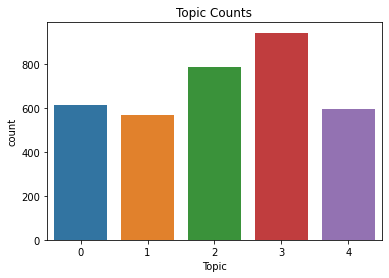

In [189]:
#  Create the bar plot
sns.countplot(x='Topic', data=topic_df)
# Set the plot title
plt.title('Topic Counts')
# Show the plot
plt.show()

In [190]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [191]:
import nltk
import re
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

# Preprocess the text data
stop_words = set(stopwords.words('english'))
sia = SentimentIntensityAnalyzer()

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuations and special characters
    text = re.sub('[^a-zA-Z0-9\s]', '', text)
    
    # Remove stop words
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [token for token in tokens if token not in stop_words]
    text = ' '.join(filtered_tokens)
    
    return text

# Apply preprocessing to the review data
df['processed_text'] = df['body'].apply(preprocess_text)

# Perform sentimental analysis
df['sentiment'] = df['processed_text'].apply(lambda x: sia.polarity_scores(x)['compound'])
def get_sentiment_category(score):
    if score > 0.8:
        return 'Highly positive'
    elif 0.2 < score <= 0.8:
        return 'Positive'
    elif -0.2 < score <= 0.2:
        return 'Neutral'
    elif -0.8 < score <= -0.2:
        return 'Negative'
    else:
        return 'Highly negative'

# Apply sentiment categorization to the sentiment column
df['sentiment'] = df['sentiment'].apply(get_sentiment_category)


<>:17: DeprecationWarning: invalid escape sequence \s
<>:17: DeprecationWarning: invalid escape sequence \s
<ipython-input-191-fea711422ece>:17: DeprecationWarning: invalid escape sequence \s
  text = re.sub('[^a-zA-Z0-9\s]', '', text)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [192]:
df

,Unnamed: 0,subject,author,date,body,type_of_traveler,seat_type,route,date_flown,recommended,processed_text,sentiment
0,0,"""made a complaint, nothing happened""",Mohammed Laidi,21st March 2023,Not Verified | I was meant to fly in January t...,Family Leisure,Economy Class,London to Algiers,May 2022,no,verified meant fly january algeria paid 300 ti...,Negative
1,1,"""Every flight was delayed""",S Walder,21st March 2023,✅ Trip Verified | We have flown repeatedly wi...,Couple Leisure,Economy Class,Miami to Munich via London,March 2023,yes,trip verified flown repeatedly british airways...,Highly negative
2,2,"""how far the quality level has slid""",L Garson,20th March 2023,✅ Trip Verified | I was horrified by the extr...,Business,Economy Class,New York to London,March 2023,no,trip verified horrified extremely small seats ...,Highly negative
3,3,"""worst cabin experience ever""",J Billot,20th March 2023,✅ Trip Verified | \r\nThe worst cabin experie...,Couple Leisure,Economy Class,Cairo to London,March 2023,no,trip verified worst cabin experience ever cram...,Highly negative
4,4,"""Very impressive and efficient""",l Higgs,18th March 2023,✅ Trip Verified | First time flying with Briti...,Solo Leisure,Premium Economy,Mumbai to Nassau via London,March 2023,yes,trip verified first time flying british airway...,Highly positive
...,...,...,...,...,...,...,...,...,...,...,...,...
3502,3502,British Airways customer review,Michael Dielissen,29th August 2012,YYZ to LHR - July 2012 - I flew overnight in p...,NaN,Premium Economy,NaN,NaN,yes,yyz lhr july 2012 flew overnight premium econo...,Highly positive
3503,3503,British Airways customer review,Nick Berry,28th August 2012,LHR to HAM. Purser addresses all club passenge...,NaN,Business Class,NaN,NaN,yes,lhr ham purser addresses club passengers name ...,Positive
3504,3504,British Airways customer review,Avril Barclay,12th October 2011,My son who had worked for British Airways urge...,NaN,Economy Class,NaN,NaN,yes,son worked british airways urged fly british a...,Positive
3505,3505,British Airways customer review,C Volz,11th October 2011,London City-New York JFK via Shannon on A318 b...,NaN,Premium Economy,NaN,NaN,no,london citynew york jfk via shannon a318 reall...,Highly positive


In [193]:
df.to_csv('sentiment_df.csv')

In [194]:
df['sentiment'].value_counts()

Highly positive    1550
Positive            703
Negative            592
Highly negative     436
Neutral             226
Name: sentiment, dtype: int64

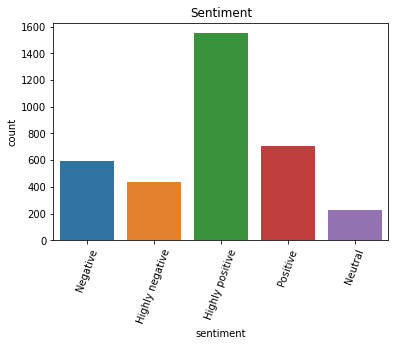

In [195]:
# Create the bar plot
sns.countplot(x='sentiment', data=df)
# Set the plot title
plt.title('Sentiment')
# Show the plot
plt.xticks(rotation=70)
plt.show()